# Detection of Movie Spoilers in Reviews

### ***Import essential libraries***

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import scipy.sparse as sp
from scipy.sparse import hstack  
from IPython.display import clear_output
import spacy
import itertools
from itertools import islice  
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Downloading necessary NLTK packages
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Understanding the data

In [2]:
# Load the dataset
original_data = pd.read_csv('movie_spoiler_sample.csv')

In [5]:
# First view of the dataset
original_data.head(5)

,movie_id,plot_summary,duration,genre,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,rating_y,review_summary
0,tt0318649,Master explorer and former US Navy Seal Dirk P...,2h 4min,"['Action', 'Adventure', 'Comedy']",6.0,2005-04-08,The film begins with a prologue set in Richmon...,27 May 2005,ur3270789,False,The film starts in the Richmond battle (1865) ...,7,Splendid adventure film with mesmerizing deser...
1,tt0803096,When the world of the Orcs of Draenor is being...,2h 3min,"['Action', 'Adventure', 'Fantasy']",6.9,2016-06-10,"For ages in the region of Middle Earth, humans...",20 June 2016,ur47788388,True,I saw the movie with six friends and we all lo...,10,Epic movie for fans and non fans
2,tt0425112,"Top London cop, PC Nicholas Angel is good. Too...",2h 1min,"['Action', 'Comedy']",7.9,2007-04-20,Nicholas Angel (Simon Pegg) is undoubtedly Lon...,11 June 2007,ur14440242,True,"I enjoyed this movie very much, but it being l...",8,once again a funny British film
3,tt0327056,In the summer of 1975 in a neighborhood in Bos...,2h 18min,"['Crime', 'Drama', 'Mystery']",8.0,2003-10-15,"Three young boys, all the best of friends, are...",5 November 2015,ur63623011,False,What you get here is no more than Clint eastwo...,1,For he made a 'plot twist' out of it
4,tt0259711,"Incarcerated and charged with murder, David Aa...",2h 16min,"['Fantasy', 'Mystery', 'Romance']",6.9,2001-12-14,"David Aames (Tom Cruise) drives to work, he fi...",12 August 2016,ur2781970,False,"I think the first time I saw this movie, I did...",10,As brilliant as I recalled it!


In [7]:
# Check the count per movie id
original_data['movie_id'].value_counts()

movie_id
tt0468569    643
tt0111161    565
tt0167260    328
tt0137523    272
tt0110912    265
            ... 
tt0383534      3
tt0110989      2
tt5580036      2
tt0107719      1
tt0374887      1
Name: count, Length: 1339, dtype: int64

In [8]:
# Check how many unique movies we have
len(original_data['movie_id'].value_counts())

1339

In [4]:
# Shape of the original dataset
original_data.shape

(72054, 13)

The dataset originally includes 72054 movie reviews.

In [5]:
# To find the number of observations of spoiler and non-spoiler
original_data['is_spoiler'].value_counts()

is_spoiler
False    36277
True     35777
Name: count, dtype: int64

The target variable is balanced (approximately 50% in each category)

However, the dataset is very large and run time error occurs therefore we decided to use undersampling to obtain a balanced sample of the data. For this reason we decided to take a sample of at most 4 reviews per movie (or less if they don't have enough reviews), 2 of spoiler and 2 non-spoiler, to maintain balanced target variable and avoid overrepresenting popular movies.

In [3]:
# Sample each movie's reviews based on the given criteria
sampled_data = original_data.groupby('movie_id', group_keys=False, as_index=False).apply(
    lambda movie_df: movie_df if len(movie_df) <= 4 else pd.concat([
        movie_df[movie_df['is_spoiler'] == True].sample(n=min(2, len(movie_df[movie_df['is_spoiler'] == True])), random_state=42),
        movie_df[movie_df['is_spoiler'] == False].sample(n=min(2, len(movie_df[movie_df['is_spoiler'] == False])), random_state=42)
    ])
).reset_index(drop=True)

sampled_data.head()

,movie_id,plot_summary,duration,genre,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,rating_y,review_summary
0,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,1 February 2006,ur5945598,True,Oh where can I start on why alleged comedians ...,10,Chaplin strikes comic gold!
1,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,11 August 2005,ur5805910,True,"We follow ""the little fellow"" (Chaplin), in hi...",10,Chaplin's delightful bonhomie & innocence
2,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,22 June 2000,ur0773000,False,I recently saw this movie with a live orchestr...,9,"As fresh, funny, and moving as the day it was ..."
3,tt0015864,A lone prospector ventures into Alaska looking...,1h 35min,"['Adventure', 'Comedy', 'Drama']",8.2,1925,It is in the middle of the Gold Rush. A Lone P...,9 March 2009,ur0361658,False,The Gold Rush (1925) was a big undertaking for...,10,The Cinema of Charles Chaplin: The Gold Rush
4,tt0017136,"Sometime in the future, the city of Metropolis...",2h 33min,"['Drama', 'Sci-Fi']",8.3,1927-03-13,"The film is set in the year 2026, in the extra...",7 March 2015,ur13977076,True,This sci-fi classic is set in a future where t...,10,A science fiction classic


In [11]:
# Number of records and features for the dataset
sampled_data.shape

(5335, 13)

In [13]:
# Check if the sample is balanced
sampled_data['is_spoiler'].value_counts()

is_spoiler
False    2677
True     2658
Name: count, dtype: int64

The target variable is balanced.

In [4]:
sampled_data['whole_review'] = sampled_data['review_text'] + sampled_data['review_summary']
sampled_data['whole_plot'] = sampled_data['plot_summary'] + sampled_data['plot_synopsis']

Named entity Recognition to find the main characters

In [17]:
# View the columns of the dataset
sampled_data.columns

Index(['movie_id', 'plot_summary', 'duration', 'genre', 'rating_x',
       'release_date', 'plot_synopsis', 'review_date', 'user_id', 'is_spoiler',
       'review_text', 'rating_y', 'review_summary', 'whole_review',
       'whole_plot'],
      dtype='object')

The target variable is balanced.

In [19]:
# Check for duplicated records
sampled_data.duplicated().any()

False

There are no duplicated records.

In [21]:
# Check the data types
sampled_data.dtypes

movie_id           object
plot_summary       object
duration           object
genre              object
rating_x          float64
release_date       object
plot_synopsis      object
review_date        object
user_id            object
is_spoiler           bool
review_text        object
rating_y            int64
review_summary     object
whole_review       object
whole_plot         object
dtype: object

In [22]:
# Save the sampled data as a csv
sampled_data.to_csv("sampled_data.csv", index=False)

In [23]:
#remove starting and trailing white spaces from strings
columns_to_strip = ['movie_id','plot_summary','duration','genre','release_date','plot_synopsis',
                            'review_date','user_id','review_text','review_summary']
sampled_data[columns_to_strip] = original_data[columns_to_strip].apply(lambda col: col.str.strip())

In [24]:
# Check for missing values
sampled_data.isna().any()

movie_id          False
plot_summary      False
duration          False
genre             False
rating_x          False
release_date      False
plot_synopsis     False
review_date       False
user_id           False
is_spoiler        False
review_text       False
rating_y          False
review_summary    False
whole_review      False
whole_plot        False
dtype: bool

There are no missing values.

In [26]:
# Check for empty strings
(sampled_data == '').sum()

movie_id          0
plot_summary      0
duration          0
genre             0
rating_x          0
release_date      0
plot_synopsis     0
review_date       0
user_id           0
is_spoiler        0
review_text       0
rating_y          0
review_summary    0
whole_review      0
whole_plot        0
dtype: int64

There are no empty strings.

In [28]:
genre = sampled_data['genre']
genre

0          ['Action', 'Adventure', 'Comedy']
1         ['Action', 'Adventure', 'Fantasy']
2                       ['Action', 'Comedy']
3              ['Crime', 'Drama', 'Mystery']
4          ['Fantasy', 'Mystery', 'Romance']
                        ...                 
5330       ['Adventure', 'Drama', 'Fantasy']
5331        ['Drama', 'History', 'Thriller']
5332           ['Action', 'Drama', 'Sci-Fi']
5333                  ['Action', 'Thriller']
5334    ['Animation', 'Adventure', 'Family']
Name: genre, Length: 5335, dtype: object

In [29]:
# Check if every element of genre feature is a string in order to make them lists
sampled_data['genre'].apply(lambda x: isinstance(x, str)).all()

True

In [30]:
# split the genres and remove the "[" "]" characters
sampled_data["genre"] = sampled_data["genre"].str.split(",")

sampled_data_exploded = sampled_data.explode('genre')
sampled_data_exploded['genre'] = sampled_data_exploded['genre'].str.replace(r"[\[\]' ]", "", regex=True)

# Apply one-hot encoding using get_dummies
sampled_data_encoded = pd.get_dummies(sampled_data_exploded['genre'])

# merge with the original dataframe
sampled_data_final = sampled_data.merge(sampled_data_encoded.groupby(sampled_data_exploded.index).sum(), left_index= True, right_index = True)

#  Drop the original 'genre' column if it's no longer needed
sampled_data_final = sampled_data_final.drop(columns=['genre'])
sampled_data = sampled_data_final

sampled_data

,movie_id,plot_summary,duration,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0318649,Master explorer and former US Navy Seal Dirk P...,2h 4min,8.2,2005-04-08,The film begins with a prologue set in Richmon...,27 May 2005,ur3270789,True,The film starts in the Richmond battle (1865) ...,...,0,0,0,0,0,0,0,0,0,0
1,tt0803096,When the world of the Orcs of Draenor is being...,2h 3min,8.2,2016-06-10,"For ages in the region of Middle Earth, humans...",20 June 2016,ur47788388,True,I saw the movie with six friends and we all lo...,...,0,0,0,0,0,0,0,0,0,0
2,tt0425112,"Top London cop, PC Nicholas Angel is good. Too...",2h 1min,8.2,2007-04-20,Nicholas Angel (Simon Pegg) is undoubtedly Lon...,11 June 2007,ur14440242,False,"I enjoyed this movie very much, but it being l...",...,0,0,0,0,0,0,0,0,0,0
3,tt0327056,In the summer of 1975 in a neighborhood in Bos...,2h 18min,8.2,2003-10-15,"Three young boys, all the best of friends, are...",5 November 2015,ur63623011,False,What you get here is no more than Clint eastwo...,...,0,0,0,1,0,0,0,0,0,0
4,tt0259711,"Incarcerated and charged with murder, David Aa...",2h 16min,8.3,2001-12-14,"David Aames (Tom Cruise) drives to work, he fi...",12 August 2016,ur2781970,True,"I think the first time I saw this movie, I did...",...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,tt0167260,The final confrontation between the forces of ...,3h 21min,8.1,2003-12-17,"In the opening scene, a flashback, two hobbits...",17 December 2003,ur2412611,False,I'm one of those who like FotR more than TTT. ...,...,0,0,0,0,0,0,0,0,0,0
5331,tt0408306,After Black September's assassination of Israe...,2h 44min,8.4,2006-01-06,The film begins with a depiction of the events...,3 February 2006,ur5683802,True,I'm not a Jew though one of my ancestors is su...,...,0,0,0,0,0,0,0,1,0,0
5332,tt1318514,"At the story's heart is Caesar (Andy Serkis), ...",1h 45min,8.4,2011-08-05,"The film opens at Gen Sys, a genetic therapy p...",4 September 2011,ur27923194,True,"Having seen all the Ape movies, I assumed I kn...",...,0,0,0,0,0,1,0,0,0,0
5333,tt1028528,"In Austin, Texas, the girlfriends Julia, Arlen...",1h 53min,8.4,2007-05-31,"Austin, Texas. The opening titles come up as S...",9 October 2007,ur8120040,False,Death Proof (2007) was a film that disappointe...,...,0,0,0,0,0,0,0,1,0,0


In [31]:
sampled_data.columns

Index(['movie_id', 'plot_summary', 'duration', 'rating_x', 'release_date',
       'plot_synopsis', 'review_date', 'user_id', 'is_spoiler', 'review_text',
       'rating_y', 'review_summary', 'whole_review', 'whole_plot', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [32]:
# Find proportion of spoiler and non spoilers for each genre
genres = sampled_data_encoded.columns

for genre in genres:
    print("Genre:", genre)
    proportions = sampled_data[sampled_data[genre] == 1].is_spoiler.value_counts(normalize=True)
    print(proportions)
    print()

Genre: Action
is_spoiler
True     0.50511
False    0.49489
Name: proportion, dtype: float64

Genre: Adventure
is_spoiler
True     0.506586
False    0.493414
Name: proportion, dtype: float64

Genre: Animation
is_spoiler
False    0.53629
True     0.46371
Name: proportion, dtype: float64

Genre: Biography
is_spoiler
False    0.523077
True     0.476923
Name: proportion, dtype: float64

Genre: Comedy
is_spoiler
False    0.52103
True     0.47897
Name: proportion, dtype: float64

Genre: Crime
is_spoiler
False    0.513026
True     0.486974
Name: proportion, dtype: float64

Genre: Drama
is_spoiler
False    0.500763
True     0.499237
Name: proportion, dtype: float64

Genre: Family
is_spoiler
True     0.533141
False    0.466859
Name: proportion, dtype: float64

Genre: Fantasy
is_spoiler
True     0.507343
False    0.492657
Name: proportion, dtype: float64

Genre: Film-Noir
is_spoiler
True     0.545455
False    0.454545
Name: proportion, dtype: float64

Genre: History
is_spoiler
False    0.514286
T

The number of records does not change.

In [34]:
# Convert duration to minutes

def convert_to_minutes(duration):
    parts = duration.replace("h", "").replace("min", "").strip().split()
    
    hours = int(parts[0]) if "h" in duration else 0
    minutes = int(parts[1]) if len(parts) > 1 else 0
    
    return hours * 60 + minutes

sampled_data['duration_minutes'] = sampled_data['duration'].apply(convert_to_minutes)
sampled_data

,movie_id,plot_summary,duration,rating_x,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,duration_minutes
0,tt0318649,Master explorer and former US Navy Seal Dirk P...,2h 4min,8.2,2005-04-08,The film begins with a prologue set in Richmon...,27 May 2005,ur3270789,True,The film starts in the Richmond battle (1865) ...,...,0,0,0,0,0,0,0,0,0,124
1,tt0803096,When the world of the Orcs of Draenor is being...,2h 3min,8.2,2016-06-10,"For ages in the region of Middle Earth, humans...",20 June 2016,ur47788388,True,I saw the movie with six friends and we all lo...,...,0,0,0,0,0,0,0,0,0,123
2,tt0425112,"Top London cop, PC Nicholas Angel is good. Too...",2h 1min,8.2,2007-04-20,Nicholas Angel (Simon Pegg) is undoubtedly Lon...,11 June 2007,ur14440242,False,"I enjoyed this movie very much, but it being l...",...,0,0,0,0,0,0,0,0,0,121
3,tt0327056,In the summer of 1975 in a neighborhood in Bos...,2h 18min,8.2,2003-10-15,"Three young boys, all the best of friends, are...",5 November 2015,ur63623011,False,What you get here is no more than Clint eastwo...,...,0,0,1,0,0,0,0,0,0,138
4,tt0259711,"Incarcerated and charged with murder, David Aa...",2h 16min,8.3,2001-12-14,"David Aames (Tom Cruise) drives to work, he fi...",12 August 2016,ur2781970,True,"I think the first time I saw this movie, I did...",...,0,0,1,1,0,0,0,0,0,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,tt0167260,The final confrontation between the forces of ...,3h 21min,8.1,2003-12-17,"In the opening scene, a flashback, two hobbits...",17 December 2003,ur2412611,False,I'm one of those who like FotR more than TTT. ...,...,0,0,0,0,0,0,0,0,0,201
5331,tt0408306,After Black September's assassination of Israe...,2h 44min,8.4,2006-01-06,The film begins with a depiction of the events...,3 February 2006,ur5683802,True,I'm not a Jew though one of my ancestors is su...,...,0,0,0,0,0,0,1,0,0,164
5332,tt1318514,"At the story's heart is Caesar (Andy Serkis), ...",1h 45min,8.4,2011-08-05,"The film opens at Gen Sys, a genetic therapy p...",4 September 2011,ur27923194,True,"Having seen all the Ape movies, I assumed I kn...",...,0,0,0,0,1,0,0,0,0,105
5333,tt1028528,"In Austin, Texas, the girlfriends Julia, Arlen...",1h 53min,8.4,2007-05-31,"Austin, Texas. The opening titles come up as S...",9 October 2007,ur8120040,False,Death Proof (2007) was a film that disappointe...,...,0,0,0,0,0,0,1,0,0,113


In [35]:
sampled_data.columns

Index(['movie_id', 'plot_summary', 'duration', 'rating_x', 'release_date',
       'plot_synopsis', 'review_date', 'user_id', 'is_spoiler', 'review_text',
       'rating_y', 'review_summary', 'whole_review', 'whole_plot', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', 'duration_minutes'],
      dtype='object')

In [36]:
# Rename rating_x, rating_y
sampled_data.rename(columns={'rating_x': 'IMDB_rating', 'rating_y': 'user_rating'}, inplace=True)

In [37]:
# Create new features that only have the year of release and the year of the review

sampled_data['release_year'] = sampled_data['release_date'].str[:4]
sampled_data['review_year'] = sampled_data['review_date'].str[-4:]

sampled_data

,movie_id,plot_summary,duration,IMDB_rating,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,...,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,duration_minutes,release_year,review_year
0,tt0318649,Master explorer and former US Navy Seal Dirk P...,2h 4min,8.2,2005-04-08,The film begins with a prologue set in Richmon...,27 May 2005,ur3270789,True,The film starts in the Richmond battle (1865) ...,...,0,0,0,0,0,0,0,124,2005,2005
1,tt0803096,When the world of the Orcs of Draenor is being...,2h 3min,8.2,2016-06-10,"For ages in the region of Middle Earth, humans...",20 June 2016,ur47788388,True,I saw the movie with six friends and we all lo...,...,0,0,0,0,0,0,0,123,2016,2016
2,tt0425112,"Top London cop, PC Nicholas Angel is good. Too...",2h 1min,8.2,2007-04-20,Nicholas Angel (Simon Pegg) is undoubtedly Lon...,11 June 2007,ur14440242,False,"I enjoyed this movie very much, but it being l...",...,0,0,0,0,0,0,0,121,2007,2007
3,tt0327056,In the summer of 1975 in a neighborhood in Bos...,2h 18min,8.2,2003-10-15,"Three young boys, all the best of friends, are...",5 November 2015,ur63623011,False,What you get here is no more than Clint eastwo...,...,1,0,0,0,0,0,0,138,2003,2015
4,tt0259711,"Incarcerated and charged with murder, David Aa...",2h 16min,8.3,2001-12-14,"David Aames (Tom Cruise) drives to work, he fi...",12 August 2016,ur2781970,True,"I think the first time I saw this movie, I did...",...,1,1,0,0,0,0,0,136,2001,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,tt0167260,The final confrontation between the forces of ...,3h 21min,8.1,2003-12-17,"In the opening scene, a flashback, two hobbits...",17 December 2003,ur2412611,False,I'm one of those who like FotR more than TTT. ...,...,0,0,0,0,0,0,0,201,2003,2003
5331,tt0408306,After Black September's assassination of Israe...,2h 44min,8.4,2006-01-06,The film begins with a depiction of the events...,3 February 2006,ur5683802,True,I'm not a Jew though one of my ancestors is su...,...,0,0,0,0,1,0,0,164,2006,2006
5332,tt1318514,"At the story's heart is Caesar (Andy Serkis), ...",1h 45min,8.4,2011-08-05,"The film opens at Gen Sys, a genetic therapy p...",4 September 2011,ur27923194,True,"Having seen all the Ape movies, I assumed I kn...",...,0,0,1,0,0,0,0,105,2011,2011
5333,tt1028528,"In Austin, Texas, the girlfriends Julia, Arlen...",1h 53min,8.4,2007-05-31,"Austin, Texas. The opening titles come up as S...",9 October 2007,ur8120040,False,Death Proof (2007) was a film that disappointe...,...,0,0,0,0,1,0,0,113,2007,2007


In [38]:
# Convert True to 1 and False to 0 in the response variable
sampled_data['is_spoiler'] = sampled_data['is_spoiler'].astype(int)
sampled_data['is_spoiler']

0       1
1       1
2       0
3       0
4       1
       ..
5330    0
5331    1
5332    1
5333    0
5334    0
Name: is_spoiler, Length: 5335, dtype: int32

### Text Pre-processing

In [41]:
# Create new dataframe for spoiler and not spoiler class
df_spoiler = sampled_data[sampled_data['is_spoiler'] == 1]
df_not_spoiler = sampled_data[sampled_data['is_spoiler'] == 0]

#### Uncontract

In [44]:
# Define the uncontract function which converts short forms to the full word. For example: 'isn't' to 'is not'.
def uncontract(text):
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)

    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)

    return text

In [45]:
sampled_data['review_text'] = [uncontract(t) for t in sampled_data['review_text']]
sampled_data['review_summary'] = [uncontract(t) for t in sampled_data['review_summary']]

In [46]:
# Create new dataframe for spoiler and not spoiler class
df_spoiler = sampled_data[sampled_data['is_spoiler'] == 1]
df_not_spoiler = sampled_data[sampled_data['is_spoiler'] == 0]

#### Tokenization

In [50]:
spoiler_tokens = [word_tokenize(t) for t in df_spoiler['whole_review']]

not_spoiler_tokens = [word_tokenize(t) for t in df_not_spoiler['whole_review']]

In [54]:
# Convert to a single list
spoiler_tokens = list(itertools.chain.from_iterable(spoiler_tokens))

not_spoiler_tokens = list(itertools.chain.from_iterable(not_spoiler_tokens))

In [55]:
# Check the number of unique tokens
print('Number of Unique Spoiler Tokens:', len(set(spoiler_tokens)))
print('Number of Unique Non-spoiler Tokens:', len(set(not_spoiler_tokens)))

Number of Unique Spoiler Tokens: 50505
Number of Unique Non-spoiler Tokens: 40262


In [56]:
# Check the most frequent tokens for Spoilers and Non-spoilers
print('Spoiler Tokens:\n')

for t, f in Counter(spoiler_tokens).most_common(10):

    print('{0:25} {1}'.format(t, f))

print()
#------------------------------------
print('Non Spoiler Tokens:\n')

for t, f in Counter(not_spoiler_tokens).most_common(10):

    print('{0:25} {1}'.format(t, f))

print()

Spoiler Tokens:

the                       46382
,                         42739
.                         34238
and                       25402
a                         23422
to                        21460
of                        21416
is                        17486
in                        13383
that                      11254

Non Spoiler Tokens:

the                       32025
,                         30217
.                         25088
and                       18750
a                         16877
of                        15589
to                        14373
is                        13083
I                         9328
in                        9128



In [57]:
def dimensionality_info(spoilertext ,nonspoilertext):

    print('Number of Spoiler Tokens:    ', len(spoilertext),     '/', len(spoiler_tokens))
    print('Number of Non Spoiler Tokens:', len(nonspoilertext), '/', len(not_spoiler_tokens))

    print()

    print('Number of Unique Spoiler Tokens:    ', len(set(spoilertext)),     '/', len(spoiler_tokens))
    print('Number of Unique Non Spoiler Tokens:', len(set(nonspoilertext)), '/', len(not_spoiler_tokens))

    print()
    print('|V|/|Tokens|:            ', len(set(spoilertext)) / len(set(spoiler_tokens)))
    print('|V|/|Tokens|:            ', len(set(nonspoilertext)) / len(set(not_spoiler_tokens)))

We observe that the most frequent tokens are stopwords. For that reason we will remvove them to get more informative result.

#### Remove Punctuation and Stopwords

##### Remove Punctuation

In [62]:
spoiler_punctuations = list(
    filter(
        lambda t: all(c.isdigit() or c in string.punctuation for c in t),
        spoiler_tokens
    )
)
#--------------------------------------
non_spoiler_punctuations = list(
    filter(
        lambda t: all(c.isdigit() or c in string.punctuation for c in t),
        not_spoiler_tokens
    )
)

In [63]:
spoiler_punctuations = set(spoiler_punctuations)

non_spoiler_punctuations = set(non_spoiler_punctuations)

In [64]:
# Remove punctuation
spoiler_clean_tokens = [t for t in spoiler_tokens if t not in spoiler_punctuations]

non_spoiler_clean_tokens = [t for t in not_spoiler_tokens if t not in non_spoiler_punctuations]

##### Remove Stopwords

In [74]:
stop_word_regex = '|'.join(['^{}$'.format(s) for s in stopwords.words('english')])

stop_word_regex = re.compile(stop_word_regex)

In [75]:
spoiler_stop_words = list(filter(stop_word_regex.match, spoiler_clean_tokens))

non_spoiler_stop_words = list(filter(stop_word_regex.match, non_spoiler_clean_tokens))
#----------------------------------------------------
spoiler_stop_words = set(spoiler_stop_words)

non_spoiler_stop_words = set(non_spoiler_stop_words)

In [76]:
# Remove stopwords
spoiler_clean_tokens = [t for t in spoiler_clean_tokens if t not in spoiler_stop_words]

non_spoiler_clean_tokens = [t for t in non_spoiler_clean_tokens if t not in non_spoiler_stop_words]

Check the most frequent tokens after removing punctuation and stopwords.

In [95]:
# Check again the most frequent tokens for Spoilers and Non-spoilers
print('Clean Spoiler Tokens:\n')

for t, f in Counter(spoiler_clean_tokens).most_common(10):

    print('{0:25} {1}'.format(t, f))

print()
#------------------------------------
print('Clean Non Spoiler Tokens:\n')

for t, f in Counter(non_spoiler_clean_tokens).most_common(10):

    print('{0:25} {1}'.format(t, f))

print()

Clean Spoiler Tokens:

I                         10988
's                        9686
movie                     6808
The                       5916
film                      5624
n't                       4986
one                       3203
like                      2896
It                        2405
good                      2063

Clean Non Spoiler Tokens:

I                         9328
's                        6743
movie                     6358
film                      4835
The                       4344
n't                       3787
one                       2588
like                      2148
It                        2076
good                      1843



We can observe that the possesive s does not give much information. Therefore we decided to consider it as a stopword and remove it.

In [97]:
spoiler_clean_tokens = [t for t in spoiler_clean_tokens if t != "'s"]

non_spoiler_clean_tokens = [t for t in non_spoiler_clean_tokens if t != "'s"]

#### Normalization

##### Lowercasing

In [101]:
spoiler_clean_tokens     = [t.lower() for t in spoiler_clean_tokens]

non_spoiler_clean_tokens     = [t.lower() for t in non_spoiler_clean_tokens]

##### Stemming

In [103]:
ps = PorterStemmer()

stems_spoiler = [ps.stem(t) for t in spoiler_clean_tokens]
stems_non_spoiler = [ps.stem(t) for t in non_spoiler_clean_tokens]

In [106]:
print('Spoiler Stems:\n')

for t, f in Counter(stems_spoiler).most_common(10):
    print('{0:25} {1}'.format(t, f))

print()
#-----------------------------
print('Non Spoiler Stems:\n')

for t, f in Counter(stems_non_spoiler).most_common(10):
    print('{0:25} {1}'.format(t, f))

print()

Spoiler Stems:

i                         10989
movi                      8033
film                      6683
the                       6046
n't                       5004
one                       3643
like                      3454
charact                   2712
it                        2548
time                      2453

Non Spoiler Stems:

i                         9329
movi                      7570
film                      5814
the                       4448
n't                       3799
one                       2917
like                      2581
it                        2175
charact                   2047
good                      1966



In [107]:
dimensionality_info(stems_spoiler, stems_non_spoiler)

Number of Spoiler Tokens:     506174 / 1021153
Number of Non Spoiler Tokens: 364236 / 730968

Number of Unique Spoiler Tokens:     33314 / 1021153
Number of Unique Non Spoiler Tokens: 26725 / 730968

|V|/|Tokens|:             0.6596178596178596
|V|/|Tokens|:             0.6637772589538523


##### Lemmatizing

In [109]:
lemmatizer = WordNetLemmatizer()

lemmas_spoiler = [lemmatizer.lemmatize(t) for t in spoiler_clean_tokens]
lemmas_non_spoiler = [lemmatizer.lemmatize(t) for t in non_spoiler_clean_tokens]

In [110]:
print('Spoiler Lemmas:\n')

for t, f in Counter(lemmas_spoiler).most_common(10):
    print('{0:25} {1}'.format(t, f))

print()
#-----------------------------
print('Non Spoiler Lemmas:\n')

for t, f in Counter(lemmas_non_spoiler).most_common(10):
    print('{0:25} {1}'.format(t, f))

print()

Spoiler Lemmas:

i                         10988
movie                     8033
film                      6599
the                       6046
n't                       5004
one                       3643
like                      3082
character                 2712
it                        2548
time                      2428

Non Spoiler Lemmas:

i                         9328
movie                     7570
film                      5718
the                       4448
n't                       3799
one                       2917
like                      2290
it                        2175
character                 2047
good                      1952



In [111]:
dimensionality_info(lemmas_spoiler, lemmas_non_spoiler)

Number of Spoiler Tokens:     506174 / 1021153
Number of Non Spoiler Tokens: 364236 / 730968

Number of Unique Spoiler Tokens:     40430 / 1021153
Number of Unique Non Spoiler Tokens: 32250 / 730968

|V|/|Tokens|:             0.8005148005148005
|V|/|Tokens|:             0.8010034275495505


In [113]:
#Many of the spoiler and non-spoiler most common words are the same - therefore we can try to isolate the 
#most common words that appear *only* in spoiler reviews and *only* in negative reviews

In [114]:
##############################################
# Define an informative function to view the #
# information of frequencies between the two #
# sets of tokens passed as input.            #
##############################################

def comparison_info(spoiler, nonspoiler, desc=None, n=10):

    print(f'{desc.capitalize()} only in Spoiler reviews:')
    print()

    spoilerfreq = dict(Counter(spoiler))
    nonspoilerfreq = dict(Counter(nonspoiler))

    onlyspoiler = set(spoilerfreq).difference(set(nonspoilerfreq))
    onlynonspoiler = set(nonspoilerfreq).difference(set(spoilerfreq))
    common   = set(spoilerfreq).intersection(set(nonspoilerfreq))

    for u in sorted(onlyspoiler, key=lambda t: spoilerfreq[t], reverse=True)[:n]: print('- {0:35} {1}'.format(u, spoilerfreq[u]))

    print()
    print(f'{desc.capitalize()} only in Non-Spoiler Reviews:')
    print()

    for u in sorted(onlynonspoiler, key=lambda t: nonspoilerfreq[t], reverse=True)[:n]: print('- {0:35} {1}'.format(u, nonspoilerfreq[u]))

    print()
    print(f'{desc.capitalize()} common in Spoiler and Non spoiler reviews:')
    print()

    print('{0:37} {1:10} {2:10}'.format('Token', 'Spoiler', 'Non Spoiler'))
    print('------------------------------------------------------------')

    for u in sorted(common, key=lambda t: spoilerfreq[t] + nonspoilerfreq[t], reverse=True)[:n]:

        print('- {0:35} {1:<10} {2:<10}'.format(u, spoilerfreq[u], nonspoilerfreq[u]))

For Lemmatization:

In [122]:
comparison_info(
  lemmas_spoiler,
  lemmas_non_spoiler,
  desc = 'Lemmas',
  n    = 10
)

Lemmas only in Spoiler reviews:

- dir                                 30
- edmond                              26
- ant                                 25
- sheeta                              21
- backdraft                           19
- pazu                                19
- atticus                             18
- susanna                             17
- alvy                                16
- replacement                         16

Lemmas only in Non-Spoiler Reviews:

- algren                              15
- spiderwick                          12
- harding                             11
- ivy                                 10
- percy                               10
- shu                                 10
- drillbit                            9
- feig                                9
- tadashi                             9
- hairspray                           9

Lemmas common in Spoiler and Non spoiler reviews:

Token                                 Spoiler    Non Spoiler


Comment: mallon ta results pano ennen toso useful : perhaps removing ALL common words in both spoiler and non spoiler is a bit harsh and removes way too many words/ much info. 

Another approach we can follow is:, we remove the top 10 common in both lemmas (ie movie, a, film, the, i, good, great etc. since they dont give much information on whether a review contains a spoiler or not. 

After doing so we can check the results and filter more words out if needed.

For Stemming:

In [125]:
comparison_info(
  stems_spoiler,
  stems_non_spoiler,
  desc = 'Stems',
  n    = 10
)

Stems only in Spoiler reviews:

- dir                                 30
- edmond                              26
- sheeta                              21
- pazu                                19
- backdraft                           19
- atticu                              18
- psychlo                             17
- susanna                             17
- alvi                                16
- nzt                                 16

Stems only in Non-Spoiler Reviews:

- algren                              15
- spiderwick                          12
- ivi                                 10
- perci                               10
- katsumoto                           10
- shu                                 10
- drillbit                            9
- feig                                9
- tadashi                             9
- hairspray                           9

Stems common in Spoiler and Non spoiler reviews:

Token                                 Spoiler    Non Spoiler
---

Still no useful results. This was kind of expected since we have different movies (different plots)

#### Create Preprocessing function with all the preprocessing steps

In [133]:
#using stemming
def pre_processing(text):
    text = uncontract(text)
    text = text.lower()
    
    clean_tokens = word_tokenize(text)

    #remove punctuation and stop words
    punctuations = set(filter(lambda t: all(c.isdigit() or c in string.punctuation for c in t), clean_tokens))
    clean_tokens = [t for t in clean_tokens if t not in punctuations]
    clean_tokens = [t for t in clean_tokens if t != "'s"]
    clean_tokens = [re.sub(stop_word_regex, '', t) for t in clean_tokens]
    
    for i, t in enumerate(clean_tokens):

        t = ps.stem(t)

        clean_tokens[i] = t
    
    return [t for t in clean_tokens if len(t) > 0]

In [134]:
X = sampled_data['whole_review']
y = sampled_data['is_spoiler'] #this is encoded 0: not spoiler, 1: spoiler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [137]:
#pre processing
X_train = [pre_processing(t) for t in X_train]
X_test  = [pre_processing(t) for t in X_test]

In [138]:
print("Size of training sample: ", len(X_train)); print("Size of test sample: ", len(X_test))

Size of training sample:  4268
Size of test sample:  1067


## Word Embeddings

Split dataset into training and testing.

In [144]:
def _(doc): return doc

### Bag of Words

In [329]:
def extract_ngrams_bow(data, ngram_range=(1, 1)):
    n_grams = CountVectorizer(
        ngram_range   = ngram_range,
        tokenizer     = _,
        preprocessor  = _,
        max_features  = 1000,
        min_df        = 1,
        max_df        = 0.8
    )

    X = n_grams.fit_transform(data)

    return X, n_grams

In [330]:
train_vec_bow, train_bow = extract_ngrams_bow(X_train, ngram_range=(1, 2)) #we use unigrams and bigrams
test_vec_bow = train_bow.transform(X_test)

C:\Users\evich\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [336]:
train_vec_bow.shape

(4268, 1000)

#### Train the Classifier

##### Naive Bayes

In [339]:
# Train the Multinomial Naive Bayes Classifier using the BoW embeddings
nb_bow = MultinomialNB()
nb_bow.fit(train_vec_bow, y_train)

MultinomialNB()

In [340]:
# Test the Multinomial Naive Bayes of BoW embeddings
y_predict_class_bow_nb = nb_bow.predict(test_vec_bow)

##### Random Forest Classifier

In [342]:
# Train the Random Forest Classifier using the BoW embeddings
rf_bow = RandomForestClassifier()
rf_bow.fit(train_vec_bow, y_train)

RandomForestClassifier()

In [343]:
# Test the Random Forest Classifier of BoW embeddings
y_predict_class_bow_rf = rf_bow.predict(test_vec_bow)

#### Performance of Classifiers on unseen test data

We will print the classification report, where we can see the Precision, Recall and F1-score for each one of the classifiers, using the BoW Embeddings. Our main focus is on the Recall metric, since we aim at minimizing the False Negatives (i.e. the reviews that are classified as Not Spoiler), when in reality they are Spoilers. We chose this particular metric, since a person that has not seen a movie, but is interested in watching it, will likely get unhuppy if they read a Spoiler review.

In [347]:
print("Classification Report of Naive Bayes Classifier (BoW)")
print("")
print(classification_report(y_test, y_predict_class_bow_nb))
print('------------------------------------------------------------')
print("Classification Report of Random Forest Classifier (BoW)")
print("")
print(classification_report(y_test, y_predict_class_bow_rf))

Classification Report of Naive Bayes Classifier (BoW)

              precision    recall  f1-score   support

           0       0.66      0.73      0.69       547
           1       0.68      0.59      0.63       520

    accuracy                           0.67      1067
   macro avg       0.67      0.66      0.66      1067
weighted avg       0.67      0.67      0.66      1067

------------------------------------------------------------
Classification Report of Random Forest Classifier (BoW)

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       547
           1       0.63      0.70      0.66       520

    accuracy                           0.65      1067
   macro avg       0.65      0.65      0.65      1067
weighted avg       0.65      0.65      0.65      1067



From the output we can observe that both the Macro and Micro average of the Recall score is a little higher for Naive Bayes Classifier. However, those scores are relatively low for both classifiers. Following, we present other Embedding techniques that will hopefully better capture the context of the Reviews and produce embeddings that will enable our Classifiers to perform better.

### TF-IDF

In [352]:
def extract_ngrams_tfidf(data, ngram_range=(1, 1), max_features=1000):

    n_grams = TfidfVectorizer(
        ngram_range  = ngram_range,
        max_features = max_features,
        tokenizer    = _,
        preprocessor = _,
        min_df       = 1,
        max_df       = 0.8
    )

    X = n_grams.fit_transform(data)

    return X, n_grams

In [353]:
train_vec_tfidf, train_tfidf = extract_ngrams_tfidf(X_train, ngram_range=(1, 3))
test_vec_tfidf = train_tfidf.transform(X_test)

C:\Users\evich\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Following we can see the first 5 rows of the TF-IDF matrix we have just created. Those rows correspond to the first 5 review records that we have, and the value in each cell corresponds to the TF-IDF score of each token (feature) for each review.

In [356]:
tfidf_df = pd.DataFrame(train_vec_tfidf.toarray())
tfidf_df.columns = train_tfidf.get_feature_names_out()

tfidf_df.head(5)

,'d,'the,abil,abl,absolut,accent,accept,achiev,across,act,...,written,wrong,ye,year,year old,yet,york,young,zombi,
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.038710,0.075724,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.087779,0.000000,0.0,0.071003,0.0,0.0,0.0,0.0
2,0.054798,0.0,0.0,0.0,0.000000,0.0,0.0,0.069085,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.086619,0.0,0.0,0.000000,0.0,0.056135,...,0.0,0.0,0.000000,0.000000,0.0,0.146309,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [357]:
print('Number of Documents:      ', train_vec_tfidf.shape[0])

print('Number of N-Gram Features:', train_vec_tfidf.shape[1])

Number of Documents:       4268
Number of N-Gram Features: 1000


#### Train the Classifier

##### Naive Bayes

In [360]:
# Train the Multinomial Naive Bayes Classifier using the TF-IDF embeddings
nb_tfidf = MultinomialNB()
nb_tfidf.fit(train_vec_tfidf, y_train)

MultinomialNB()

In [361]:
# Test the Multinomial Naive Bayes of TF-IDF embeddings
y_predict_class_tfidf_nb = nb_tfidf.predict(test_vec_tfidf)

##### Random Forest

In [363]:
# Train the Random Forest Classifier using the TF-IDF embeddings
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(train_vec_tfidf, y_train)

RandomForestClassifier()

In [364]:
# Test the Random Forest Classifier of TF-IDF embeddings
y_predict_class_tfidf_rf = rf_tfidf.predict(test_vec_tfidf)

#### Performance of Classifiers on unseen test data

We will print the classification report for each of the two classifiers.

In [368]:
print("Classification Report of Naive Bayes Classifier (TF-IDF)")
print("")
print(classification_report(y_test, y_predict_class_tfidf_nb))
print('------------------------------------------------------------')
print("Classification Report of Random Forest Classifier (TF-IDF)")
print("")
print(classification_report(y_test, y_predict_class_tfidf_rf))

Classification Report of Naive Bayes Classifier (TF-IDF)

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       547
           1       0.65      0.62      0.63       520

    accuracy                           0.65      1067
   macro avg       0.65      0.65      0.65      1067
weighted avg       0.65      0.65      0.65      1067

------------------------------------------------------------
Classification Report of Random Forest Classifier (TF-IDF)

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       547
           1       0.63      0.63      0.63       520

    accuracy                           0.64      1067
   macro avg       0.64      0.64      0.64      1067
weighted avg       0.64      0.64      0.64      1067



From the above output we observe that the Recall for both classifiers is similar to that of the BoW ebeddings approach, and it is still quite low.

### Word2Vec

In [372]:
# We use a pre-trained model based on the GoogleNews
wv_model = api.load('word2vec-google-news-300')

In [373]:
def get_document_vector(document_tokens):

  document_vectors = []

  for t in document_tokens:

    ##########################
    # Check if token exists  #
    # in the word2vec model. #
    ##########################

    if t in wv_model: document_vectors.append(wv_model[t])

  return np.mean(document_vectors, axis=0)

In [374]:
train_vec_wv = [get_document_vector(t) for t in X_train]
test_vec_wv  = [get_document_vector(t) for t in X_test]

#### Train the Classifier

In contrast with the previous word embedding approaches, we cannot use the Naive Bayes classifier, since in this case the embeddings contain negative values.

##### Random Forest

In [379]:
# Train the Random Forest Classifier using the WordVector embeddings
rf_wv = RandomForestClassifier()
rf_wv.fit(train_vec_wv, y_train)

RandomForestClassifier()

In [380]:
# Test the Random Forest Classifier of WordVector embeddings
y_predict_class_wv_rf = rf_wv.predict(test_vec_wv)

#### Performance of Classifier on unseen test data

We will print the classification report for Random Forest Classifier.

In [387]:
print("Classification Report of Random Forest Classifier (WordVec)")
print("")
print(classification_report(y_test, y_predict_class_wv_rf))

Classification Report of Random Forest Classifier (WordVec)

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       547
           1       0.64      0.58      0.61       520

    accuracy                           0.64      1067
   macro avg       0.64      0.63      0.63      1067
weighted avg       0.64      0.64      0.64      1067



## Using NER and POS embeddings as well as the rest of the review to train a logistic regression

In the next cell we will find the main characters of each film based on the number of occurences of the names of characters in the whole_plot column

In [155]:

# Load spaCy model optimized for NER only
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])  # Only keep NER for speed

# Prepare plot texts grouped by 'movie_id'
plot_texts = sampled_data.groupby("movie_id")["whole_plot"].apply(lambda x: " ".join(x)).to_dict()

# Store NER results
person_entities_by_movie = defaultdict(list)

# =================== Batch Process with nlp.pipe() ===================
# Using .values() directly to get only the texts
# Slice the dictionary to the first 10 items
sliced_plot_texts = dict(islice(plot_texts.items(), 10))

docs = nlp.pipe(sliced_plot_texts.values(), batch_size=50, n_process=4)  # Adjust n_process to your core count

# =================== Extract Named Entities (NER) ===================
for (movie_id, text), doc in zip(sliced_plot_texts.items(), docs):
    person_entities = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    
    # Count occurrences and keep only the top 3
    person_counts = Counter(person_entities)
    top_persons = person_counts.most_common(3)
    
    # Store the top persons for each movie
    person_entities_by_movie[movie_id].extend([entity for entity, _ in top_persons])

    # Print the top 3 most common PERSON entities with their counts for each movie
    print(f"\nMovie ID: {movie_id} - Most Common PERSON Entities:")
    for entity, count in top_persons:
        print(f"{entity}: {count} times")
    print("="*40)



Movie ID: tt0015864 - Most Common PERSON Entities:
Evelyn: 26 times
Jake: 15 times
Mulwray: 11 times

Movie ID: tt0017136 - Most Common PERSON Entities:
Sylvia: 27 times
Sidney: 21 times
Raymond: 16 times

Movie ID: tt0017925 - Most Common PERSON Entities:
Josh: 26 times
Pete: 23 times
Walter: 10 times

Movie ID: tt0018455 - Most Common PERSON Entities:
Merrick: 63 times
Jo: 52 times
Mario: 36 times

Movie ID: tt0021749 - Most Common PERSON Entities:
Allison: 36 times
Baldwin: 18 times
Vernon-Williams: 8 times

Movie ID: tt0022100 - Most Common PERSON Entities:
Lisbon: 8 times
Mary: 3 times
Bonnie: 3 times

Movie ID: tt0025316 - Most Common PERSON Entities:
Barry: 70 times
Skeeter: 27 times
Hilly: 24 times

Movie ID: tt0031381 - Most Common PERSON Entities:
Kay: 231 times
Jay: 157 times
Edwards: 72 times

Movie ID: tt0031679 - Most Common PERSON Entities:
Norman: 55 times
Sam: 28 times
Marion: 21 times

Movie ID: tt0032138 - Most Common PERSON Entities:
Saroo: 49 times
Dorothy: 38 tim

We will perform NER only for a specific movie, with `movie_id` = "tt0032138" (Wizzard of Oz), to display its WordCloud for our presentation. In the following cell I write again some things that we import in previous cells because I don't have time to re-run the previous proccess. I only run the necessary cells. The top 3 persons are presented in the previous output so I don't print them again.

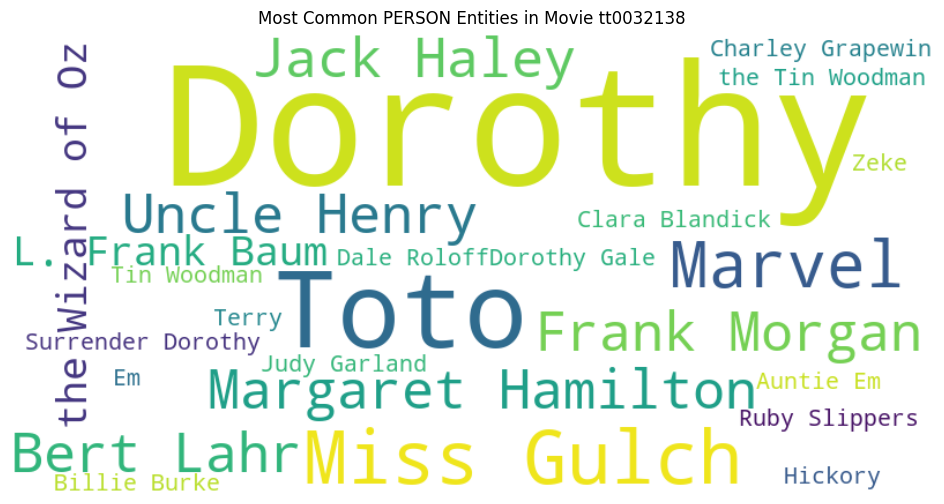

Word cloud saved as: person_wordcloud_tt0032138.png


In [7]:
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Filter only the reviews for the given movie ID
target_movie_id = "tt0032138"
movie_text = " ".join(sampled_data[sampled_data["movie_id"] == target_movie_id]["whole_plot"])

# Perform NER on the full text
doc = nlp(movie_text)
person_entities = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]

# Count occurrences of each person entity
person_counts = Counter(person_entities)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(person_counts)

# Plot and save the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Most Common PERSON Entities in Movie {target_movie_id}")

# Save the image
output_path = f"person_wordcloud_{target_movie_id}.png"
plt.savefig(output_path, bbox_inches='tight', dpi=300)

# Show the image
plt.show()

print(f"Word cloud saved as: {output_path}")

In [ ]:
### to do this for all movies uncomment and run this cell (takes a long time to run)
'''
import spacy
from collections import Counter, defaultdict
import pandas as pd

# Load spaCy model optimized for NER only
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])  # Only keep NER for speed

# Prepare plot texts grouped by 'movie_id'
plot_texts = sampled_data.groupby("movie_id")["whole_plot"].apply(lambda x: " ".join(x)).to_dict()

# Store NER results
person_entities_by_movie = defaultdict(list)

# =================== Batch Process with nlp.pipe() ===================
# Using .values() directly to get only the texts
docs = nlp.pipe(plot_texts.values(), batch_size=50, n_process=4)  # Adjust n_process to your core count

# =================== Extract Named Entities (NER) ===================
for (movie_id, text), doc in zip(plot_texts.items(), docs):
    person_entities = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    
    # Count occurrences and keep only the top 3
    person_counts = Counter(person_entities)
    top_persons = person_counts.most_common(3)
    
    # Store the top persons for each movie
    person_entities_by_movie[movie_id].extend([entity for entity, _ in top_persons])

# =================== Print Only 10 Movies ===================
# Select only the first 10 movies from the results
selected_movies = dict(list(person_entities_by_movie.items())[:10])

for movie_id, entities in selected_movies.items():
    print(f"\nMovie ID: {movie_id} - Most Common PERSON Entities:")
    for entity in entities:
        print(f"{entity}")
    print("="*40)
'''

### We may also use POS embeddings to train classifiers.

In [157]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "lemmatizer"])

# Step 1: Preprocess each review (one review per row)
processed_tokens_list = [pre_processing(text) for text in sampled_data['whole_review']]
token_texts = [" ".join(tokens) for tokens in processed_tokens_list]  # for token BoW

# Step 2: Extract POS tags using spaCy for each review
docs = list(nlp.pipe(token_texts, batch_size=100, n_process=4))
pos_texts = [" ".join([token.pos_ for token in doc]) for doc in docs]

# Step 3: Create DataFrame using DataFrame index as unique review ID
combined_df = pd.DataFrame({
    'token_text': token_texts,
    'pos_text': pos_texts,
    'is_spoiler': sampled_data['is_spoiler'].values
}, index=sampled_data.index)

# Step 4: Vectorize token and POS text
token_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_tokens = token_vectorizer.fit_transform(combined_df['token_text'])

pos_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_pos = pos_vectorizer.fit_transform(combined_df['pos_text'])

# Step 5: Combine features
X_combined = hstack([X_tokens, X_pos])

# Step 6: Prepare labels and train-test split
y = combined_df['is_spoiler']
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)


In [158]:
# Train a Logistic Regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report Logistic Regression:\n")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Classification Report Logistic Regression:

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       535
           1       0.61      0.57      0.59       532

    accuracy                           0.61      1067
   macro avg       0.61      0.61      0.60      1067
weighted avg       0.61      0.61      0.60      1067

Accuracy: 0.61


C:\Users\evich\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [159]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       535
           1       0.61      0.65      0.63       532

    accuracy                           0.62      1067
   macro avg       0.62      0.62      0.62      1067
weighted avg       0.62      0.62      0.62      1067

Random Forest Accuracy: 0.62


In [160]:
#Also train a naive bayes classifier

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Evaluate the Naive Bayes model
print("\nClassification Report Naive Bayes:\n")
print(classification_report(y_test, y_pred_nb))
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.2f}")


Classification Report Naive Bayes:

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       535
           1       0.63      0.55      0.59       532

    accuracy                           0.61      1067
   macro avg       0.62      0.61      0.61      1067
weighted avg       0.62      0.61      0.61      1067

Naive Bayes Accuracy: 0.61
